# IoT GNN Demo

## Env Setup
To use this notebook, a conda environment has to be created beforehand. Commands to create the environment and install the minimal packages:
```bash
conda create -n iot_env python=3.11
conda activate iot_env
conda install pytorch
conda install pandas
conda install scikit-learn
conda install matplotlib
conda install pytorch::torchdata
conda install conda-forge::dgl
```  
Then, the conda environment has to be exported.  
```bash
conda install ipykernel
python -m ipykernel install --user --name iot_env --display-name "Python (iot_env)"
```  
Select the iot_env kernel to run the ipynb.

## Imports

In [1]:
from configuration import *

from models import e_graphsage, fnn_model, e_graphsage_hembed
from data import IoTDataset
import train
from train import ModelTrainer
import tester

/home/rowleyra/anaconda3/envs/iot_env/lib/python3.11/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()
/home/rowleyra/anaconda3/envs/iot_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# NF-BoT-IoT

## Randomized IP Addresses and Ports

### Load Data
This assumes there is a "data" folder under the root of the IoT_GNN repo.  
Datasets can be found at: https://drive.google.com/drive/folders/14t41P09gXTsCqPx3YFN1Pruwb2eZQrkT?usp=share_link

In [2]:
multiclass = True
randomized_ip_train_data = IoTDataset(version=1, multiclass=multiclass)
randomized_ip_val_data = IoTDataset(version=1, multiclass=multiclass, split='val')
randomized_ip_test_data = IoTDataset(version=1, multiclass=multiclass, split='test')

### Model Initialization

In [3]:
# Multiclass
model_egs = e_graphsage.E_GraphSAGE(numLayers=2,
                                dim_node_embed=128,
                                num_edge_attr=randomized_ip_train_data.num_features,
                                num_classes=len(randomized_ip_train_data.classes)
                              )
model_egs_cpu = e_graphsage.E_GraphSAGE(numLayers=2,
                                dim_node_embed=128,
                                num_edge_attr=randomized_ip_train_data.num_features,
                                num_classes=len(randomized_ip_train_data.classes)
                              )
model_fnn = fnn_model.TestFNN(num_hidden_layers=2,
                              hidden_layer_widths=[128, 192],  # Should be approximately comparable to EGS
                              num_edge_attr=randomized_ip_train_data.num_features,
                              num_classes=len(randomized_ip_train_data.classes),
                            )
model_egsh = e_graphsage_hembed.E_GraphSAGE_hEmbed(numLayers=2,
                                                   dim_node_embed=96,       # Approximately equal parameter count as EGS
                                                   num_edge_attr=randomized_ip_train_data.num_features,
                                                   num_classes=len(randomized_ip_train_data.classes)
                                                  )

In [4]:
# Multiclass
# 175 epochs sufficient for EGS to get plateau of validation risk.
egs_training_config = {
        'num_epochs': 300,
        'lr': 1e-3,
        'gpu': True,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
egs_training_config_cpu = {
        'num_epochs': 300,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
# 205 epochs for the FNN
fnn_training_config = {
        'num_epochs': 205,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
egsh_training_config = {
        'num_epochs': 205,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}

### Training

In [20]:
import importlib
importlib.reload(train)

<module 'train' from '/home/rowleyra/IoT_GNN/train.py'>

In [5]:
# Instantiate Trainer
# Multiclass
egs_trainer = ModelTrainer(egs_training_config, randomized_ip_train_data, randomized_ip_val_data)
egs_trainer_cpu = ModelTrainer(egs_training_config_cpu, randomized_ip_train_data, randomized_ip_val_data)
fnn_trainer = ModelTrainer(fnn_training_config, randomized_ip_train_data, randomized_ip_val_data)
egsh_trainer = ModelTrainer(egsh_training_config, randomized_ip_train_data, randomized_ip_val_data)

In [6]:
# Train the GNN
_ = egs_trainer.train_model(model_egs, False)

Training E_GraphSAGE_K2_H128:   0%|          | 1/300 [00:00<01:48,  2.74epoch/s, train loss=1.6117, validation loss=1.5776, learning rate=1.00e-03, F1 score=0.00758]

[Epoch 0] logit mean: -0.0497, std: 0.0683


Training E_GraphSAGE_K2_H128:   9%|▊         | 26/300 [00:05<00:48,  5.64epoch/s, train loss=1.1385, validation loss=1.1407, learning rate=1.00e-03, F1 score=0.79541]

[Epoch 25] logit mean: 0.0714, std: 0.6953


Training E_GraphSAGE_K2_H128:  17%|█▋        | 51/300 [00:09<00:48,  5.10epoch/s, train loss=0.9130, validation loss=0.9314, learning rate=1.00e-03, F1 score=0.79514]

[Epoch 50] logit mean: 0.0177, std: 1.3393


Training E_GraphSAGE_K2_H128:  25%|██▌       | 76/300 [00:14<00:48,  4.62epoch/s, train loss=0.7841, validation loss=0.8438, learning rate=1.00e-03, F1 score=0.76636]

[Epoch 75] logit mean: -0.0117, std: 1.7513


Training E_GraphSAGE_K2_H128:  34%|███▎      | 101/300 [00:20<00:44,  4.46epoch/s, train loss=0.7401, validation loss=0.7916, learning rate=1.00e-03, F1 score=0.76220]

[Epoch 100] logit mean: -0.0403, std: 1.9706


Training E_GraphSAGE_K2_H128:  42%|████▏     | 126/300 [00:24<00:30,  5.78epoch/s, train loss=0.6840, validation loss=0.7628, learning rate=1.00e-03, F1 score=0.76188]

[Epoch 125] logit mean: -0.0865, std: 2.2689


Training E_GraphSAGE_K2_H128:  51%|█████     | 152/300 [00:29<00:25,  5.86epoch/s, train loss=0.6620, validation loss=0.7433, learning rate=1.00e-03, F1 score=0.74965]

[Epoch 150] logit mean: -0.1173, std: 2.4952


Training E_GraphSAGE_K2_H128:  59%|█████▊    | 176/300 [00:34<00:22,  5.49epoch/s, train loss=0.6479, validation loss=0.7175, learning rate=1.00e-03, F1 score=0.75220]

[Epoch 175] logit mean: -0.1683, std: 2.7419


Training E_GraphSAGE_K2_H128:  67%|██████▋   | 201/300 [00:39<00:18,  5.38epoch/s, train loss=0.6133, validation loss=0.7088, learning rate=1.00e-03, F1 score=0.78105]

[Epoch 200] logit mean: -0.1981, std: 2.9599


Training E_GraphSAGE_K2_H128:  75%|███████▌  | 226/300 [00:44<00:16,  4.36epoch/s, train loss=0.6168, validation loss=0.7072, learning rate=1.00e-03, F1 score=0.75144]

[Epoch 225] logit mean: -0.1956, std: 3.0589


Training E_GraphSAGE_K2_H128:  84%|████████▎ | 251/300 [00:49<00:09,  5.07epoch/s, train loss=0.6075, validation loss=0.6939, learning rate=3.16e-05, F1 score=0.75010]

[Epoch 250] logit mean: -0.2079, std: 3.1098


Training E_GraphSAGE_K2_H128:  92%|█████████▏| 276/300 [00:54<00:05,  4.60epoch/s, train loss=0.6156, validation loss=0.6939, learning rate=3.16e-06, F1 score=0.75050]

[Epoch 275] logit mean: -0.2094, std: 3.1120


Training E_GraphSAGE_K2_H128: 100%|██████████| 300/300 [00:58<00:00,  5.10epoch/s, train loss=0.6167, validation loss=0.6939, learning rate=3.16e-07, F1 score=0.75050]


In [7]:
# Train the GNN
_ = egs_trainer_cpu.train_model(model_egs_cpu, False)

Training E_GraphSAGE_K2_H128:   0%|          | 1/300 [00:01<07:15,  1.46s/epoch, train loss=1.6182, validation loss=1.5937, learning rate=1.00e-03, F1 score=0.02111]

[Epoch 0] logit mean: 0.0056, std: 0.0579


Training E_GraphSAGE_K2_H128:   9%|▊         | 26/300 [00:33<05:38,  1.24s/epoch, train loss=1.1721, validation loss=1.1478, learning rate=1.00e-03, F1 score=0.76454]

[Epoch 25] logit mean: 0.1151, std: 0.6255


Training E_GraphSAGE_K2_H128:  17%|█▋        | 51/300 [01:04<05:05,  1.22s/epoch, train loss=0.9758, validation loss=0.9437, learning rate=1.00e-03, F1 score=0.79424]

[Epoch 50] logit mean: 0.2241, std: 1.2684


Training E_GraphSAGE_K2_H128:  25%|██▌       | 76/300 [01:35<04:54,  1.32s/epoch, train loss=0.7979, validation loss=0.8462, learning rate=1.00e-03, F1 score=0.76650]

[Epoch 75] logit mean: 0.1905, std: 1.6218


Training E_GraphSAGE_K2_H128:  34%|███▎      | 101/300 [02:06<04:17,  1.29s/epoch, train loss=0.7144, validation loss=0.7899, learning rate=1.00e-03, F1 score=0.76326]

[Epoch 100] logit mean: 0.1776, std: 1.9675


Training E_GraphSAGE_K2_H128:  42%|████▏     | 126/300 [02:37<03:30,  1.21s/epoch, train loss=0.7187, validation loss=0.7567, learning rate=1.00e-03, F1 score=0.76106]

[Epoch 125] logit mean: 0.1713, std: 2.2993


Training E_GraphSAGE_K2_H128:  50%|█████     | 151/300 [03:08<03:04,  1.24s/epoch, train loss=0.6800, validation loss=0.7390, learning rate=1.00e-03, F1 score=0.75183]

[Epoch 150] logit mean: 0.1346, std: 2.5366


Training E_GraphSAGE_K2_H128:  59%|█████▊    | 176/300 [03:39<02:35,  1.26s/epoch, train loss=0.6478, validation loss=0.7200, learning rate=1.00e-03, F1 score=0.78312]

[Epoch 175] logit mean: 0.1112, std: 2.6785


Training E_GraphSAGE_K2_H128:  67%|██████▋   | 201/300 [04:11<02:06,  1.28s/epoch, train loss=0.6463, validation loss=0.7067, learning rate=1.00e-03, F1 score=0.75284]

[Epoch 200] logit mean: 0.0896, std: 2.7848


Training E_GraphSAGE_K2_H128:  75%|███████▌  | 226/300 [04:45<01:33,  1.27s/epoch, train loss=0.6203, validation loss=0.7026, learning rate=1.00e-04, F1 score=0.75040]

[Epoch 225] logit mean: 0.0760, std: 2.8863


Training E_GraphSAGE_K2_H128:  84%|████████▎ | 251/300 [05:17<01:01,  1.25s/epoch, train loss=0.6062, validation loss=0.7015, learning rate=1.00e-05, F1 score=0.78095]

[Epoch 250] logit mean: 0.0765, std: 2.8897


Training E_GraphSAGE_K2_H128:  92%|█████████▏| 276/300 [05:49<00:30,  1.26s/epoch, train loss=0.6303, validation loss=0.7005, learning rate=1.00e-05, F1 score=0.78095]

[Epoch 275] logit mean: 0.0765, std: 2.8886


Training E_GraphSAGE_K2_H128: 100%|██████████| 300/300 [06:21<00:00,  1.27s/epoch, train loss=0.6277, validation loss=0.7010, learning rate=1.00e-06, F1 score=0.78095]


In [29]:
# Train the FCNN
_ = fnn_trainer.train_model(model_fnn, False)

Training FCNN_K2:   0%|          | 1/205 [00:00<02:22,  1.44epoch/s, train loss=1.5991, validation loss=1.5427, learning rate=1.00e-03, F1 score=0.04893]

[Epoch 0] logit mean: 0.0020, std: 0.0815


Training FCNN_K2:  13%|█▎        | 26/205 [00:18<02:06,  1.41epoch/s, train loss=1.2450, validation loss=1.1191, learning rate=1.00e-03, F1 score=0.76644]

[Epoch 25] logit mean: -0.0196, std: 0.6757


Training FCNN_K2:  25%|██▍       | 51/205 [00:35<01:46,  1.45epoch/s, train loss=1.1394, validation loss=0.9515, learning rate=1.00e-03, F1 score=0.76349]

[Epoch 50] logit mean: -0.0626, std: 1.1687


Training FCNN_K2:  37%|███▋      | 76/205 [00:52<01:28,  1.46epoch/s, train loss=1.0931, validation loss=0.8729, learning rate=1.00e-03, F1 score=0.76755]

[Epoch 75] logit mean: -0.0939, std: 1.4659


Training FCNN_K2:  49%|████▉     | 101/205 [01:09<01:10,  1.48epoch/s, train loss=1.0698, validation loss=0.8272, learning rate=1.00e-03, F1 score=0.77624]

[Epoch 100] logit mean: -0.1120, std: 1.7451


Training FCNN_K2:  61%|██████▏   | 126/205 [01:27<00:53,  1.47epoch/s, train loss=1.0615, validation loss=0.8022, learning rate=1.00e-03, F1 score=0.77144]

[Epoch 125] logit mean: -0.1264, std: 1.9642


Training FCNN_K2:  74%|███████▎  | 151/205 [01:44<00:39,  1.38epoch/s, train loss=1.0473, validation loss=0.7815, learning rate=1.00e-03, F1 score=0.77848]

[Epoch 150] logit mean: -0.1380, std: 2.1985


Training FCNN_K2:  86%|████████▌ | 176/205 [02:01<00:19,  1.46epoch/s, train loss=1.0272, validation loss=0.7605, learning rate=1.00e-03, F1 score=0.78133]

[Epoch 175] logit mean: -0.1528, std: 2.5076


Training FCNN_K2:  98%|█████████▊| 201/205 [02:19<00:02,  1.34epoch/s, train loss=1.0262, validation loss=0.7405, learning rate=1.00e-03, F1 score=0.78548]

[Epoch 200] logit mean: -0.1734, std: 2.9378


Training FCNN_K2: 100%|██████████| 205/205 [02:22<00:00,  1.44epoch/s, train loss=1.0194, validation loss=0.7360, learning rate=1.00e-03, F1 score=0.79401]


In [ ]:
# Train the EGSH
_ = egsh_trainer.train_model(model_egsh, False)

### Testing

TODO: Clean up the tester  
2025/11/30 I think this is mostly done. Just need to clean up for binary classification.
17:00 It is clean now.

In [31]:
# If modify tester
import importlib
importlib.reload(tester)

<module 'tester' from '/home/rowleyra/IoT_GNN/tester.py'>

In [32]:
tester_inst = tester.ModelTester(randomized_ip_test_data, False)

data: cpu
logits: cpu target: cpu loss weight: cpu
Total Samples: 120020
===== Multiclass Test Report =====
== Benign ==
Precision: 0.187274
Recall:    0.915224
F1-score:  0.310926

== DDoS ==
Precision: 0.000000
Recall:    0.000000
F1-score:  0.000000

== DoS ==
Precision: 0.388942
Recall:    0.974663
F1-score:  0.556007

== Reconnaissance ==
Precision: 0.995147
Recall:    0.788624
F1-score:  0.879930

== Theft ==
Precision: 0.050428
Recall:    0.447644
F1-score:  0.090644

== weighted avg ==
Precision: 0.821810
Recall:    0.733386
F1-score:  0.750253

= Global Metrics =
Accuracy:           0.733386
Balanced Accuracy:  0.625231

Confusion Matrix:
[[ 2537     1    55   111    68]
 [   22     0 11097    19   230]
 [   28     0 11079    21   239]
 [10960     0  6254 74234  2683]
 [    0     0     0   211   171]]

= Binary Metrics =
TN, TP, FN, FP are derived from the confusion matrix.
Benign is the negative class. The attack classes are positive.
Total Samples: 120020
TN: 2537
TP: 106238

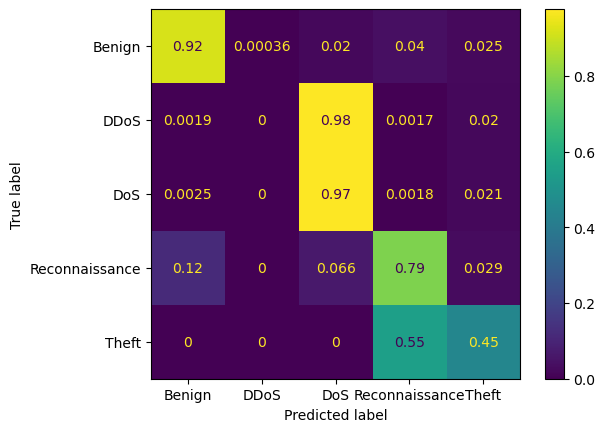

In [33]:
tester_inst.test_model(model_egs)

data: cpu
logits: cpu target: cpu loss weight: cpu
Total Samples: 120020
===== Multiclass Test Report =====
== Benign ==
Precision: 0.187574
Recall:    0.911616
F1-score:  0.311130

== DDoS ==
Precision: 0.341561
Recall:    0.573364
F1-score:  0.428098

== DoS ==
Precision: 0.489118
Recall:    0.405296
F1-score:  0.443279

== Reconnaissance ==
Precision: 0.995033
Recall:    0.789634
F1-score:  0.880514

== Theft ==
Precision: 0.050209
Recall:    0.439791
F1-score:  0.090129

== weighted avg ==
Precision: 0.863567
Recall:    0.734453
F1-score:  0.780586

= Global Metrics =
Accuracy:           0.734453
Balanced Accuracy:  0.623940

Confusion Matrix:
[[ 2527    56     0   120    69]
 [   22  6518  4583    19   226]
 [   28  6476  4607    21   235]
 [10895  6033   226 74329  2648]
 [    0     0     3   211   168]]

= Binary Metrics =
TN, TP, FN, FP are derived from the confusion matrix.
Benign is the negative class. The attack classes are positive.
Total Samples: 120020
TN: 2527
TP: 106303

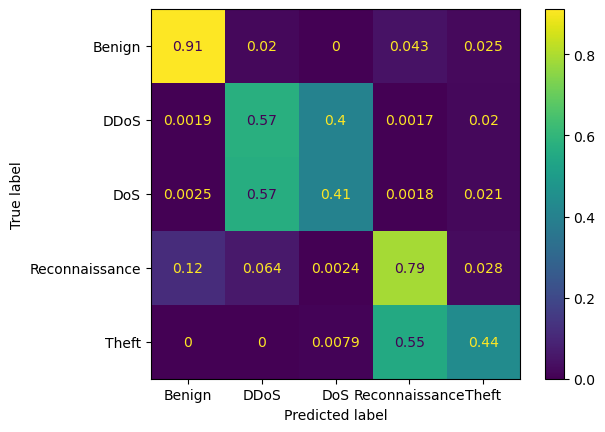

In [34]:
tester_inst.test_model(model_egs_cpu)

data: cuda:0
logits: cuda:0 target: cuda:0 loss weight: cuda:0
Total Samples: 120020
===== Multiclass Test Report =====
== Benign ==
Precision: 0.187274
Recall:    0.915224
F1-score:  0.310926

== DDoS ==
Precision: 0.000000
Recall:    0.000000
F1-score:  0.000000

== DoS ==
Precision: 0.388942
Recall:    0.974663
F1-score:  0.556007

== Reconnaissance ==
Precision: 0.995147
Recall:    0.788624
F1-score:  0.879930

== Theft ==
Precision: 0.050428
Recall:    0.447644
F1-score:  0.090644

== weighted avg ==
Precision: 0.821810
Recall:    0.733386
F1-score:  0.750253

= Global Metrics =
Accuracy:           0.733386
Balanced Accuracy:  0.625231

Confusion Matrix:
[[ 2537     1    55   111    68]
 [   22     0 11097    19   230]
 [   28     0 11079    21   239]
 [10960     0  6254 74234  2683]
 [    0     0     0   211   171]]

= Binary Metrics =
TN, TP, FN, FP are derived from the confusion matrix.
Benign is the negative class. The attack classes are positive.
Total Samples: 120020
TN: 253

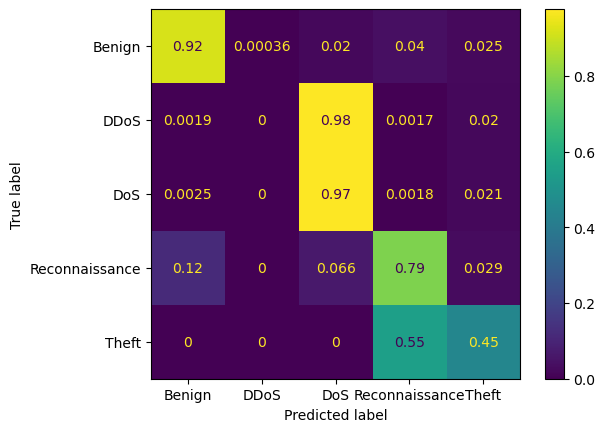

In [36]:
tester_inst_gpu = tester.ModelTester(randomized_ip_test_data, True)
tester_inst_gpu.test_model(model_egs)

In [ ]:
tester_inst.test_model(model_fnn)

In [ ]:
tester_inst.test_model(model_egsh)

## Non-Randomized IP Addresses and Ports

### Load Data

In [ ]:
multiclass = True
orig_ip_train_data = IoTDataset(version=1, multiclass=multiclass, randomize_source_ip=False)
orig_ip_val_data = IoTDataset(version=1, multiclass=multiclass, split='val', randomize_source_ip=False)
orig_ip_test_data = IoTDataset(version=1, multiclass=multiclass, split='test', randomize_source_ip=False)

### Model Initialization

In [ ]:
# Multiclass
model_egs_orig = e_graphsage.E_GraphSAGE(numLayers=2,
                                dim_node_embed=128,
                                num_edge_attr=orig_ip_train_data.num_features,
                                num_classes=len(orig_ip_train_data.classes)
                                )
model_fnn_orig = fnn_model.TestFNN(num_hidden_layers=2,
                              hidden_layer_widths=[128, 192],  # Should be approximately comparable to EGS
                              num_edge_attr=orig_ip_train_data.num_features,
                              num_classes=len(orig_ip_train_data.classes),
                            )
model_egsh_orig = e_graphsage_hembed.E_GraphSAGE_hEmbed(numLayers=2,
                                                   dim_node_embed=96,       # Approximately equal parameter count as EGS
                                                   num_edge_attr=orig_ip_train_data.num_features,
                                                   num_classes=len(orig_ip_train_data.classes)
                                                  )

### Training

In [ ]:
# Multiclass
# 175 epochs sufficient for EGS to get plateau of validation risk.
egs_orig_training_config = {
        'num_epochs': 175,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
# 205 epochs for the FNN
fnn_orig_training_config = {
        'num_epochs': 205,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
egsh_orig_training_config = {
        'num_epochs': 205,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}

In [ ]:
# Instantiate Trainer
# Multiclass
egs_orig_trainer = ModelTrainer(egs_orig_training_config, orig_ip_train_data, orig_ip_val_data)
fnn_orig_trainer = ModelTrainer(fnn_orig_training_config, orig_ip_train_data, orig_ip_val_data)
egsh_orig_trainer = ModelTrainer(egsh_orig_training_config, orig_ip_train_data, orig_ip_val_data)

In [ ]:
# Train the GNN
_ = egs_orig_trainer.train_model(model_egs_orig, False)

In [ ]:
# Train the FCNN
_ = fnn_orig_trainer.train_model(model_fnn_orig, False)

In [ ]:
# Train the EGSH
_ = egsh_orig_trainer.train_model(model_egsh_orig, False)

### Testing

In [ ]:
tester_inst_orig = tester.ModelTester(orig_ip_test_data, False)

In [ ]:
tester_inst_orig.test_model(model_egs_orig)

In [ ]:
tester_inst_orig.test_model(model_fnn_orig)

In [ ]:
tester_inst_orig.test_model(model_egsh_orig)

# NF-ToN-IoT

## Randomized IP Addresses and Ports

### Load Data
This assumes there is a "data" folder under the root of the IoT_GNN repo.  
Datasets can be found at: https://drive.google.com/drive/folders/14t41P09gXTsCqPx3YFN1Pruwb2eZQrkT?usp=share_link

In [ ]:
multiclass = True
ton_randomized_ip_train_data = IoTDataset(dataset='NF-ToN-IoT', version=1, multiclass=multiclass)
ton_randomized_ip_val_data = IoTDataset(dataset='NF-ToN-IoT', version=1, multiclass=multiclass, split='val')
ton_randomized_ip_test_data = IoTDataset(dataset='NF-ToN-IoT', version=1, multiclass=multiclass, split='test')

### Model Initialization

In [ ]:
# Multiclass
model_egs_ton = e_graphsage.E_GraphSAGE(numLayers=2,
                                dim_node_embed=128,
                                num_edge_attr=ton_randomized_ip_train_data.num_features,
                                num_classes=len(ton_randomized_ip_train_data.classes)
                                )
model_fnn_ton = fnn_model.TestFNN(num_hidden_layers=2,
                              hidden_layer_widths=[128, 192],  # Should be approximately comparable to EGS
                              num_edge_attr=ton_randomized_ip_train_data.num_features,
                              num_classes=len(ton_randomized_ip_train_data.classes),
                            )
model_egsh_ton = e_graphsage_hembed.E_GraphSAGE_hEmbed(numLayers=2,
                                                   dim_node_embed=96,       # Approximately equal parameter count as EGS
                                                   num_edge_attr=ton_randomized_ip_train_data.num_features,
                                                   num_classes=len(ton_randomized_ip_train_data.classes)
                                                  )

### Training

In [ ]:
# Multiclass
# 175 epochs sufficient for EGS to get plateau of validation risk.
egs_training_config_ton = {
        'num_epochs': 1000,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
# 205 epochs for the FNN
fnn_training_config_ton = {
        'num_epochs': 1000,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
egsh_training_config_ton = {
        'num_epochs': 1000,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}

In [ ]:
# Instantiate Trainer
# Multiclass
egs_trainer_ton = ModelTrainer(egs_training_config_ton, ton_randomized_ip_train_data, ton_randomized_ip_val_data)
fnn_trainer_ton = ModelTrainer(fnn_training_config_ton, ton_randomized_ip_train_data, ton_randomized_ip_val_data)
egsh_trainer_ton = ModelTrainer(egsh_training_config_ton, ton_randomized_ip_train_data, ton_randomized_ip_val_data)

In [ ]:
# Train the GNN
_ = egs_trainer_ton.train_model(model_egs_ton, False)

In [ ]:
# Train the FCNN
_ = fnn_trainer_ton.train_model(model_fnn_ton, False)

In [ ]:
# Train the EGSH
_ = egsh_trainer_ton.train_model(model_egsh_ton, False)

### Testing

In [ ]:
# If modify tester
import importlib
importlib.reload(tester)

In [ ]:
tester_inst_ton = tester.ModelTester(ton_randomized_ip_test_data, False)

In [ ]:
tester_inst_ton.test_model(model_egs_ton)

In [ ]:
tester_inst_ton.test_model(model_fnn_ton)

In [ ]:
tester_inst_ton.test_model(model_egsh_ton)

## Non-Randomized IP Addresses and Ports

### Load Data

In [ ]:
multiclass = True
ton_orig_ip_train_data = IoTDataset(dataset='NF-ToN-IoT', version=1, multiclass=multiclass, randomize_source_ip=False)
ton_orig_ip_val_data = IoTDataset(dataset='NF-ToN-IoT', version=1, multiclass=multiclass, split='val', randomize_source_ip=False)
ton_orig_ip_test_data = IoTDataset(dataset='NF-ToN-IoT', version=1, multiclass=multiclass, split='test', randomize_source_ip=False)

### Model Initialization

In [ ]:
# Multiclass
model_egs_orig_ton = e_graphsage.E_GraphSAGE(numLayers=2,
                                dim_node_embed=128,
                                num_edge_attr=ton_orig_ip_train_data.num_features,
                                num_classes=len(ton_orig_ip_train_data.classes)
                                )
model_fnn_orig_ton = fnn_model.TestFNN(num_hidden_layers=2,
                              hidden_layer_widths=[128, 192],  # Should be approximately comparable to EGS
                              num_edge_attr=ton_orig_ip_train_data.num_features,
                              num_classes=len(ton_orig_ip_train_data.classes),
                            )
model_egsh_orig_ton = e_graphsage_hembed.E_GraphSAGE_hEmbed(numLayers=2,
                                                   dim_node_embed=96,       # Approximately equal parameter count as EGS
                                                   num_edge_attr=ton_orig_ip_train_data.num_features,
                                                   num_classes=len(ton_orig_ip_train_data.classes)
                                                  )

### Training

In [ ]:
# Multiclass
# 175 epochs sufficient for EGS to get plateau of validation risk.
egs_orig_training_config_ton = {
        'num_epochs': 1000,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
# 205 epochs for the FNN
fnn_orig_training_config_ton = {
        'num_epochs': 1000,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
egsh_orig_training_config_ton = {
        'num_epochs': 1000,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}

In [ ]:
# Instantiate Trainer
# Multiclass
egs_orig_trainer_ton = ModelTrainer(egs_orig_training_config_ton, ton_orig_ip_train_data, ton_orig_ip_val_data)
fnn_orig_trainer_ton = ModelTrainer(fnn_orig_training_config_ton, ton_orig_ip_train_data, ton_orig_ip_val_data)
egsh_orig_trainer_ton = ModelTrainer(egsh_orig_training_config_ton, ton_orig_ip_train_data, ton_orig_ip_val_data)

In [ ]:
# Train the GNN
_ = egs_orig_trainer_ton.train_model(model_egs_orig_ton, False)

In [ ]:
# Train the FCNN
_ = fnn_orig_trainer_ton.train_model(model_fnn_orig_ton, False)

In [ ]:
# Train the EGSH
_ = egsh_orig_trainer_ton.train_model(model_egsh_orig_ton, False)

### Testing

In [ ]:
tester_inst_orig_ton = tester.ModelTester(ton_orig_ip_test_data, False)

In [ ]:
tester_inst_orig_ton.test_model(model_egs_orig_ton)

In [ ]:
tester_inst_orig_ton.test_model(model_fnn_orig_ton)

In [ ]:
tester_inst_orig_ton.test_model(model_egsh_orig_ton)

# NF-UNSW-NB15

## Randomized IP Addresses and Ports

### Load Data
This assumes there is a "data" folder under the root of the IoT_GNN repo.  
Datasets can be found at: https://drive.google.com/drive/folders/14t41P09gXTsCqPx3YFN1Pruwb2eZQrkT?usp=share_link

In [ ]:
multiclass = True
nsw_randomized_ip_train_data = IoTDataset(dataset='NF-UNSW-NB15', version=1, multiclass=multiclass)
nsw_randomized_ip_val_data = IoTDataset(dataset='NF-UNSW-NB15', version=1, multiclass=multiclass, split='val')
nsw_randomized_ip_test_data = IoTDataset(dataset='NF-UNSW-NB15', version=1, multiclass=multiclass, split='test')

### Model Initialization

In [ ]:
# Multiclass
model_egs_nsw = e_graphsage.E_GraphSAGE(numLayers=2,
                                dim_node_embed=128,
                                num_edge_attr=nsw_randomized_ip_train_data.num_features,
                                num_classes=len(nsw_randomized_ip_train_data.classes)
                                )
model_fnn_nsw = fnn_model.TestFNN(num_hidden_layers=2,
                              hidden_layer_widths=[128, 192],  # Should be approximately comparable to EGS
                              num_edge_attr=nsw_randomized_ip_train_data.num_features,
                              num_classes=len(nsw_randomized_ip_train_data.classes),
                            )
model_egsh_nsw = e_graphsage_hembed.E_GraphSAGE_hEmbed(numLayers=2,
                                                   dim_node_embed=96,       # Approximately equal parameter count as EGS
                                                   num_edge_attr=nsw_randomized_ip_train_data.num_features,
                                                   num_classes=len(nsw_randomized_ip_train_data.classes)
                                                  )

### Training

In [ ]:
# Multiclass
# 175 epochs sufficient for EGS to get plateau of validation risk.
egs_training_config_nsw = {
        'num_epochs': 1000,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
# 205 epochs for the FNN
fnn_training_config_nsw = {
        'num_epochs': 1000,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
egsh_training_config_nsw = {
        'num_epochs': 1000,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}

In [ ]:
# Instantiate Trainer
# Multiclass
egs_trainer_nsw = ModelTrainer(egs_training_config_nsw, nsw_randomized_ip_train_data, nsw_randomized_ip_val_data)
fnn_trainer_nsw = ModelTrainer(fnn_training_config_nsw, nsw_randomized_ip_train_data, nsw_randomized_ip_val_data)
egsh_trainer_nsw = ModelTrainer(egsh_training_config_nsw, nsw_randomized_ip_train_data, nsw_randomized_ip_val_data)

In [ ]:
# Train the GNN
_ = egs_trainer_nsw.train_model(model_egs_nsw, False)

In [ ]:
# Train the FCNN
_ = fnn_trainer_nsw.train_model(model_fnn_nsw, False)

In [ ]:
# Train the EGSH
_ = egsh_trainer_nsw.train_model(model_egsh_nsw, False)

### Testing

In [ ]:
# If modify tester
import importlib
importlib.reload(tester)

In [ ]:
tester_inst_nsw = tester.ModelTester(nsw_randomized_ip_test_data, False)

In [ ]:
tester_inst_nsw.test_model(model_egs_nsw)

In [ ]:
tester_inst_nsw.test_model(model_fnn_nsw)

In [ ]:
tester_inst_nsw.test_model(model_egsh_nsw)

## Non-Randomized IP Addresses and Ports

### Load Data

In [ ]:
multiclass = True
nsw_orig_ip_train_data = IoTDataset(dataset='NF-UNSW-NB15', version=1, multiclass=multiclass, randomize_source_ip=False)
nsw_orig_ip_val_data = IoTDataset(dataset='NF-UNSW-NB15', version=1, multiclass=multiclass, split='val', randomize_source_ip=False)
nsw_orig_ip_test_data = IoTDataset(dataset='NF-UNSW-NB15', version=1, multiclass=multiclass, split='test', randomize_source_ip=False)

### Model Initialization

In [ ]:
# Multiclass
model_egs_orig_nsw = e_graphsage.E_GraphSAGE(numLayers=2,
                                dim_node_embed=128,
                                num_edge_attr=nsw_orig_ip_train_data.num_features,
                                num_classes=len(nsw_orig_ip_train_data.classes)
                                )
model_fnn_orig_nsw = fnn_model.TestFNN(num_hidden_layers=2,
                              hidden_layer_widths=[128, 192],  # Should be approximately comparable to EGS
                              num_edge_attr=nsw_orig_ip_train_data.num_features,
                              num_classes=len(nsw_orig_ip_train_data.classes),
                            )
model_egsh_orig_nsw = e_graphsage_hembed.E_GraphSAGE_hEmbed(numLayers=2,
                                                   dim_node_embed=96,       # Approximately equal parameter count as EGS
                                                   num_edge_attr=nsw_orig_ip_train_data.num_features,
                                                   num_classes=len(nsw_orig_ip_train_data.classes)
                                                  )

### Training

In [ ]:
# Multiclass
# 175 epochs sufficient for EGS to get plateau of validation risk.
egs_orig_training_config_nsw = {
        'num_epochs': 1000,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
# 205 epochs for the FNN
fnn_orig_training_config_nsw = {
        'num_epochs': 1000,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}
egsh_orig_training_config_nsw = {
        'num_epochs': 1000,
        'lr': 1e-3,
        'gpu': False,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 10,
}

In [ ]:
# Instantiate Trainer
# Multiclass
egs_orig_trainer_nsw = ModelTrainer(egs_orig_training_config_nsw, nsw_orig_ip_train_data, nsw_orig_ip_val_data)
fnn_orig_trainer_nsw = ModelTrainer(fnn_orig_training_config_nsw, nsw_orig_ip_train_data, nsw_orig_ip_val_data)
egsh_orig_trainer_nsw = ModelTrainer(egsh_orig_training_config_nsw, nsw_orig_ip_train_data, nsw_orig_ip_val_data)

In [ ]:
# Train the GNN
_ = egs_orig_trainer_nsw.train_model(model_egs_orig_nsw, False)

In [ ]:
# Train the FCNN
_ = fnn_orig_trainer_nsw.train_model(model_fnn_orig_nsw, False)

In [ ]:
# Train the EGSH
_ = egsh_orig_trainer_nsw.train_model(model_egsh_orig_nsw, False)

### Testing

In [ ]:
tester_inst_orig_nsw = tester.ModelTester(nsw_orig_ip_test_data, False)

In [ ]:
tester_inst_orig_nsw.test_model(model_egs_orig_nsw)

In [ ]:
tester_inst_orig_nsw.test_model(model_fnn_orig_nsw)

In [ ]:
tester_inst_orig_nsw.test_model(model_egsh_orig_nsw)